In [1]:
import torch
from torch import nn
from torch.autograd.functional import vhp
import copy
import numpy as np

torch.manual_seed(0)

In [2]:
def pow_reducer(x):
  return x.pow(3).sum()


def pow_adder_reducer(x, y):
  return (2 * x.pow(4) + 3 * y.pow(3) + x.pow(3)*y.pow(5)).sum()


The inputs are what the Hessian is computed with respect to. Here it is just x's; for us it will be model parameters. This is fine, because loss functions are set up that way: inputs are fixed and the gradients are with respect to params. I am a little unclear on how to pass params to vhp. 

In [3]:
ishape = (4)
inputs = torch.rand(ishape)
v = torch.ones(ishape) # all ones, so just copies 

In [4]:

vhp(pow_reducer, inputs, v)


(tensor(0.5786), tensor([2.9775, 4.6093, 0.5309, 0.7922]))

Math for pow_reducer Hessian:

\begin{align}
  & f\left( \mathbf{x} \right)=\sum\limits_{i=1}^{4}{x_{i}^{3}} \\ 
 & \frac{\partial f}{\partial {{x}_{j}}}=\sum\limits_{i=1}^{4}{3x_{i}^{2}{{\delta }_{ij}}}=3x_{j}^{2} \\ 
 & \frac{{{\partial }^{2}}f}{\partial {{x}_{k}}\partial {{x}_{j}}}=\sum\limits_{i=1}^{4}{6{{x}_{i}}{{\delta }_{ij}}}{{\delta }_{ik}}=6{{x}_{j}}{{\delta }_{jk}} \\ 
\end{align}


Ok, so that's the Hessian, it's a matrix. When I dot it with a vector of ones, I get a vector that's just each input x times 6. 

In [5]:
print(pow_reducer(inputs))
print(6*inputs)

tensor(0.5786)
tensor([2.9775, 4.6093, 0.5309, 0.7922])


I think I need to say create_graph=True, but I can't remember why. 

In [6]:
vhp(pow_reducer, inputs, v, create_graph=True)


(tensor(0.5786, grad_fn=<SumBackward0>),
 tensor([2.9775, 4.6093, 0.5309, 0.7922], grad_fn=<MulBackward0>))

## Check the Hessian explicitly
In the next cell, I am explicitly constructing the Hessian for pow_adder_reducer(). In actual use, the Hessian will probably be too big to construct. I just want to see if I can construct it and multiply it into the input vectors and get the same result as vhp().

In [7]:
nv = 3
inputs = (torch.rand(nv), torch.rand(nv)) #  need an x and a y
v = (torch.ones(nv), torch.ones(nv))
lp, vH = vhp(pow_adder_reducer, inputs, v, create_graph=True)
print('pow_adder_reducer:', lp)
print('check pow_adder_reducer:', pow_adder_reducer(*inputs),'\n')

print('vhp:', vH)
# for i,v in enumerate(vH):
#     print('vhp['+str(i)+']:', v.detach().numpy())

x, y = inputs
H = []
vmat = torch.zeros(2, nv)
for i in range(nv):
    vmat[0,i] = v[0][i]
    vmat[1,i] = v[1][i]
    H.append(torch.tensor([[(24*x[i]**2 + 6*x[i]*y[i]**5), (15*x[i]**2*y[i]**4)],\
                           [(15*x[i]**2*y[i]**4), (18*y[i]+20*x[i]**3*y[i]**3)]]))

vH_check = []
for i in range(nv):
    vH_check.append(vmat[:,i].t() @ H[i])

print('vmat @ H:', vH_check,'\n')

for i in range(nv):
    print(vH[0][i]-vH_check[i][0], vH[1][i]-vH_check[i][1])

pow_adder_reducer: tensor(3.6936, grad_fn=<SumBackward0>)
check pow_adder_reducer: tensor(3.6936) 

vhp: (tensor([4.2515, 9.9840, 6.6377], grad_fn=<AddBackward0>), tensor([17.4701,  8.9435, 12.5526], grad_fn=<AddBackward0>))
vmat @ H: [tensor([ 4.2515, 17.4701]), tensor([9.9840, 8.9435]), tensor([ 6.6377, 12.5526])] 

tensor(0., grad_fn=<SubBackward0>) tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>) tensor(0., grad_fn=<SubBackward0>)
tensor(4.7684e-07, grad_fn=<SubBackward0>) tensor(0., grad_fn=<SubBackward0>)


In [8]:
vH

(tensor([4.2515, 9.9840, 6.6377], grad_fn=<AddBackward0>),
 tensor([17.4701,  8.9435, 12.5526], grad_fn=<AddBackward0>))

In [9]:
vH_check

[tensor([ 4.2515, 17.4701]),
 tensor([9.9840, 8.9435]),
 tensor([ 6.6377, 12.5526])]

# VHP with respect to model parameters

The following is from a stackoverflow question about applying vhp when models with parameters are involved, as opposed to simpler functions where we don't have to iterate over parameters.

https://stackoverflow.com/questions/68492748/trouble-with-minimal-hvp-on-pytorch-model

This in turn linked to

https://discuss.pytorch.org/t/hvp-w-r-t-model-parameters/83520



In [10]:

# your simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, out_dim),
        )

    def forward(self, x):
        '''Forward pass'''
#         return self.layers(x)
        return torch.sigmoid(self.layers(x))

    



In [11]:

# your model instantiation
in_dim, out_dim = 3, 2
mlp = SimpleMLP(in_dim, out_dim)

v_to_dot = tuple([torch.rand_like(p.clone().detach()) for p in mlp.parameters()])

xglobal = torch.rand((in_dim,)) # need to eliminate this and other global refs. 


In [12]:
mlp(xglobal)

tensor([0.4889, 0.4944], grad_fn=<SigmoidBackward>)

In [13]:
# This is how we trick vhp into doing the Hessian with respect to params and not other inputs.
#
# Sadly it contains some global variables. 
def loss_wrt_params(*new_params):
    load_weights(mlp, names, new_params) # Weird! We removed the params before. 
    if len(tuple(mlp.named_parameters())) == 0:
        print('Model has no parameters!')
    for n,p in mlp.named_parameters():
        if p is None:
            print('whoops p is None!')
        else:
            print(n,p)
    out = mlp(xglobal)  # model output
    loss = objective(out)  # comparing model to ground truth, in practice. 
    
    loss.backward(retain_graph=True)
    return loss


In [14]:
mlp

SimpleMLP(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=2, bias=True)
  )
)

In [15]:

# Following are utilities to make nn.Module "functional", in the sense of 
#    being from or compatible with the torch.autograd.functional library. 
#
# borrowed from the link I posted in comment
# 
def del_attr(obj, names): # why, why, why? But it definitely breaks without this. 
    if len(names) == 1:
#         print('BEFORE:')
#         print([n for n,p in obj.named_parameters()])
        delattr(obj, names[0])
#         print('AFTER:')
#         print([n for n,p in obj.named_parameters()])
    else:
#         print('recursing',len(names))
        del_attr(getattr(obj, names[0]), names[1:])

def set_attr(obj, names, val):
    if len(names) == 1:
#         print('BEFORE:')
#         print([n for n,p in obj.named_parameters()])
        setattr(obj, names[0], val)
#         print('AFTER:')
#         print([n for n,p in obj.named_parameters()])
    else:
#         print('recursing',len(names))
        set_attr(getattr(obj, names[0]), names[1:], val)

def make_functional(model):
    orig_params = tuple(model.parameters())
    orig_grad = capture_gradients(model)
    # Remove all the parameters in the model, because reasons. 
    names = []
    for name, p in list(model.named_parameters()):
        del_attr(model, name.split("."))
        names.append(name)
    return orig_params, orig_grad, names

def load_weights(model, names, params, as_params=False):
    for name, p in zip(names, params):
        if not as_params:
            set_attr(model, name.split("."), p)
        else:
            set_attr(model, name.split("."), torch.nn.Parameter(p))

def restore_model(model, names, params, grad): # (this one is mine)
    load_weights(model, names, params, as_params=True)
    for k, v in model.named_parameters():
        if grad[k+'.grad']:
            v.grad = grad[k].clone().detach()
        else:
            v.grad = None


def capture_gradients(model): # returns gradients in dict vector form (this one is also mine)
    g = {}
    for k, v in model.named_parameters():
        gnext = v.grad
        knext = k + '.grad'
        if gnext is not None:
            next_entry = {knext: gnext.clone().detach()}
        else:
            next_entry = {knext: None}
        g.update(next_entry)
    return g
  
def sigmoid(x):
    return 1 /(1+torch.exp(-x))

def sigprime(x):
    return torch.exp(-x)*sigmoid(x)**2

def invsigmoid(x):
    return -torch.log(1/x-1)
    

In [16]:
for n, p in mlp.named_parameters():
    print(n,':',p)

layers.0.weight : Parameter containing:
tensor([[-0.1745, -0.1135, -0.5516],
        [-0.3824, -0.2380,  0.0214]], requires_grad=True)
layers.0.bias : Parameter containing:
tensor([0.2282, 0.3464], requires_grad=True)


In [17]:
len(tuple(mlp.parameters()))

2

In [18]:
#make model's parameters functional
orig_params, orig_grad, names = make_functional(mlp)
params2pass = tuple(p.detach().requires_grad_() for p in orig_params)


## The "objective function"
The function called objective() is important here. It must generate a scalar from a tensor. It takes the output of the model (called mlp(), generates a vector) and operates on it, to produce a scalar. In actual use, objective will probably somehow compare the mlp output to some ground truth. 

If objective  is linear in its input, the second derivatives in the Hessian will be zero. For some reason, Pytorch barfs on this, rather than just giving zeros.

Using absolute value as objective(), though, seems to be ok. Sure, abs is not linear, but doesn't it make the Hessian zero everywhere except X=0? Why shouldn't this cause the same issue? 

In [19]:

#  "loss" function
def objective(X):
#     return torch.sum(0.25 * torch.sum(X)**4)  # this is what the online example had. 
# derivative of objective wrt X is sum(X)**3*(ones(shape(X)))
#     return torch.sum(torch.abs(X)) # Hessians are zero, but no error thrown
    return torch.sum(X**2)
#     return torch.sum(X)  # BARF! Error thrown. 


In [20]:
loss_value, v_dot_hessian = torch.autograd.functional.vhp(loss_wrt_params, params2pass, \
                                                    v_to_dot, strict=True)


Model has no parameters!


In [21]:
len(tuple(mlp.parameters()))

0

In [22]:
restore_model(mlp, names, orig_params, orig_grad)
lossp = loss_wrt_params(*orig_params) # this calls backward on loss = objective(out)
grad = capture_gradients(mlp)
print('grad is:', grad)
# print('dLdY check is:', torch.sum())

print('loss_value:', loss_value)
print('lossp:', lossp)
print('vH(params):', v_dot_hessian)

# for p in orig_params:
#     print(p.shape)
#L=torch.sum(Y**2)/2
#Y = W * x + B
# dLdY = sum(Y)*ones(Y.shape)
# dYdWij = sum(x)


layers.0.weight Parameter containing:
tensor([[-0.1745, -0.1135, -0.5516],
        [-0.3824, -0.2380,  0.0214]], requires_grad=True)
layers.0.bias Parameter containing:
tensor([0.2282, 0.3464], requires_grad=True)
grad is: {'layers.0.weight.grad': tensor([[0.2328, 0.0088, 0.0453],
        [0.2355, 0.0089, 0.0458]]), 'layers.0.bias.grad': tensor([0.2443, 0.2472])}
loss_value: tensor(0.4835)
lossp: tensor(0.4835, grad_fn=<SumBackward0>)
vH(params): (tensor([[0.0880, 0.0033, 0.0171],
        [0.1949, 0.0074, 0.0379]]), tensor([0.0924, 0.2045]))


In [23]:
Y = mlp(xglobal)
#  Y = sigmoid(Z), Z = invsig(Y)
# Y = 1/(1+exp(-Z))  Y*(1+exp(-Z)) = 1  1/Y-1 = exp(-Z)   Z = -log(1/Y-1)
Z = invsigmoid(Y)

In [24]:
gchk = torch.zeros((2,3))
spZ = sigprime(Z)
for i in range(2):
    for j in range(3):
        gchk[i,j] = 2*spZ[i]*xglobal[j]
        
print(gchk, spZ)

tensor([[0.4761, 0.0181, 0.0926],
        [0.4763, 0.0181, 0.0926]], grad_fn=<CopySlices>) tensor([0.2499, 0.2500], grad_fn=<MulBackward0>)


Here is what the result should be above (since I set torch.manual_seed(0)). 
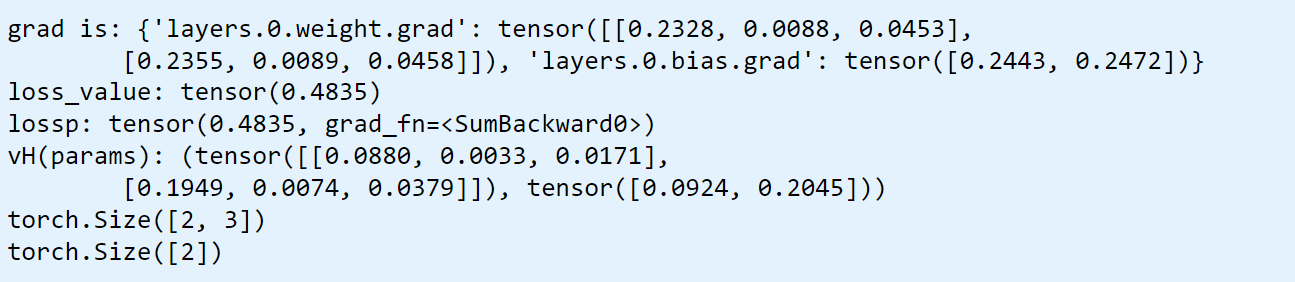

In [25]:
xglobal

tensor([0.9527, 0.0362, 0.1852])

In [26]:
loss_value-lossp

tensor(0., grad_fn=<SubBackward0>)

In [27]:
xchk =  torch.rand((in_dim,))


In [28]:
outchk = mlp(xchk)
print(outchk)
losschk = objective(outchk)
print(losschk)

tensor([0.4048, 0.5377], grad_fn=<SigmoidBackward>)
tensor(0.4529, grad_fn=<SumBackward0>)


In [29]:
capture_gradients(mlp)

{'layers.0.weight.grad': tensor([[0.2328, 0.0088, 0.0453],
         [0.2355, 0.0089, 0.0458]]),
 'layers.0.bias.grad': tensor([0.2443, 0.2472])}

In [30]:
grad

{'layers.0.weight.grad': tensor([[0.2328, 0.0088, 0.0453],
         [0.2355, 0.0089, 0.0458]]),
 'layers.0.bias.grad': tensor([0.2443, 0.2472])}

## Check the Hessian of this "parameter trick" function
First, make sure I can get the gradient of a linear function with respect to its inputs correct. The result for the in_dim to out_dim transform here should be the sum over rows of the weight matrix.  

In [31]:
class JustLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, out_dim),
        )

    def forward(self, x):
        '''Forward pass'''
#         return self.layers(x)
        return self.layers(x)



In [32]:
print(in_dim, out_dim)

3 2


In [33]:
xglobal.grad = None

xglobal.retain_grad = False
xglobal.requires_grad = True
f = JustLinear(in_dim, out_dim)

fx = f(xglobal)
ext_grad = torch.ones_like(fx)
fx.backward(gradient=ext_grad, retain_graph=True, inputs=xglobal)
print(fx)


tensor([-0.1832, -0.1556], grad_fn=<AddBackward0>)


In [34]:
print('the result of backward is:\n', xglobal.grad,'\n')

print('the sum over rows of the weight matrix is:')
for p in f.named_parameters():
    if 'weight' in p[0]:
        print(torch.sum(p[1],0))
        
print('\nThese should both be the same vector, with',in_dim,'components.')

the result of backward is:
 tensor([-0.9150, -0.6028,  0.0929]) 

the sum over rows of the weight matrix is:
tensor([-0.9150, -0.6028,  0.0929], grad_fn=<SumBackward1>)

These should both be the same vector, with 3 components.


We are taking derivatives of each output component and summing over them. I guess the sum is implicit in backward()? Otherwise I don't see how it comes about. I feel like each output component should have its own value of the gradient here. I guess I am thinking backward() should compute the Jacobian, but it does not. OMG the documentation says exactly that. Ok. 

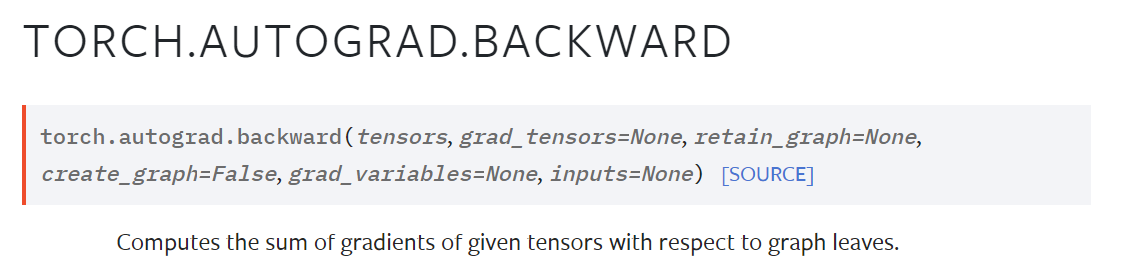

# Argh, what is a leaf node? 

The following is meant to be an example of what leaf nodes are. I think it might be helpful, even though the blog post it came from is super hard to understand and explains itself poorly. http://www.bnikolic.co.uk/blog/pytorch/python/2021/03/15/pytorch-leaf.html

In the stuff I worked through above here, I made sure to have the inputs be the leaves. I think if I used grad instead of backward, pytorch would assume that's what I wanted. 

In [35]:

import torch

x=torch.ones(10, requires_grad=True)
y=torch.ones(10, requires_grad=True)

# The remaining nodes are not leaves:
def H(z1, z2):
    ret = torch.sin(z1**3)*torch.cos(z2**2)
    return ret
# dHdz1 = cos(z1**3)*cos(z2**2)*3*z1**2
# dHdz2 = -sin(z1**3)*sin(z2**2)*2*z2

def G(z1, z2):
    return torch.exp(z1)+torch.log(z2)

def F(z1, z2):
    return z1**3*z2**0.5

h=H(x,y)

g=G(x,y)

f=F(h,g)
f.retain_grad()
f.sum().backward() # must sum to get a scalar, otherwise backward() will barf. 
                    #  No gradients are loaded until backward() is called. 
   

In [36]:
hchk = np.sin(1)*np.cos(1)
gchk = np.exp(1) + np.log(1)

In [37]:
dFdh = 3*hchk**2 *np.sqrt(gchk)
dFdg = 0.5* hchk**3 / np.sqrt(gchk)

In [38]:
dgdx = np.exp(1)
dgdy = 1.0
dhdx = np.cos(1)*np.cos(1)*3
dhdy = -np.sin(1)*np.sin(1)*2
#-sin(z1**3)*sin(z2**2)*2*z2


In [39]:
dFdx = dFdh*dhdx + dFdg*dgdx
dFdy = dFdh*dhdy + dFdg*dgdy
print('dFdx =', dFdx)
print('dFdy =', dFdy)


dFdx = 0.9728684287087229
dFdy = -1.419366770452894


In [40]:
print(dFdx - x.grad)
print(dFdy - y.grad)

tensor([-1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07,
        -1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [41]:
f.grad

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [42]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

In [43]:
Q = 3*a**3 - b**2

In [44]:
Q.retain_grad()

In [45]:
Q.sum().backward()

In [46]:
a.grad


tensor([36., 81.])

In [47]:
b.grad

tensor([-12.,  -8.])

In [48]:
a.grad, b.grad = None, None

In [49]:
Q

tensor([-12.,  65.], grad_fn=<SubBackward0>)